#Initial Library Imports

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import calendar
from matplotlib import pyplot as plt
from datetime import timedelta
plt.style.use('seaborn')
%matplotlib inline
warnings.filterwarnings("ignore")

In [0]:
!git clone https://<username>:<password>@github.com/MQCOMP6200-2020-S1/portfolio-reubenbf.git

In [4]:
%cd /content/portfolio-reubenbf

/content/portfolio-reubenbf


# Analysis of Cycling Data


## Loading Data

The first dataset is an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `scripts/stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride. 

In [0]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True)
strava.head()

The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [0]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')
cheetah.head()

The GoldenCheetah data contains many many variables (columns) and I won't go into all of them here. Some
that are of particular interest for the analysis below are:

Here are definitions of some of the more important fields in the data. **Capitalised fields come from the GoldenCheetah** data
while **lowercase_fields come from Strava**. There are many cases where fields are duplicated and in this case the values
should be the same, although there is room for variation as the algorithm used to calculate them could be different
in each case. 

  * Duration - overall duration of the ride, should be same as `elapsed_time`
  * Time Moving - time spent moving (not resting or waiting at lights), should be the same as `moving_time`
  * Elevation Gain - metres climbed over the ride
  * Average Speed - over the ride
  * Average Power - average power in watts as measured by a power meter, relates to how much effort is being put in to the ride, should be the same as  `average_watts` from Strava
  * Nonzero Average Power - same as Average Power but excludes times when power is zero from the average
  * Average Heart Rate - should be the same as average_heartrate
  * Average Cadence - cadence is the rotations per minute of the pedals
  * Average Temp - temperature in the environment as measured by the bike computer (should be same as `average_temp`)
  * VAM - average ascent speed - speed up hills
  * Calories (HR) - Calorie expendature as estimated from heart rate data
  * 1 sec Peak Power - this and other  'Peak Power' measures give the maximum power output in the ride over this time period.  Will be higher for shorter periods. High values in short periods would come from a very 'punchy' ride with sprints for example.
  * 1 min Peak Hr - a similar measure relating to Heart Rate
  * NP - Normalised Power, a smoothed average power measurement, generally higher than Average Power 
  * TSS - Training Stress Score, a measure of how hard a ride this was
  * device_watts - True if the power (watts) measures were from a power meter, False if they were estimated
  * distance - distance travelled in Km
  * kudos - likes from other Strava users (social network)
  * workout_type - one of  'Race',  'Workout' or  'Ride'
  
  
Some of the GoldenCheetah parameters are defined [in thier documentation](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary).  

## Assigned Task


### Combining Strava and Cheetah data

Combining the two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index). The goal is to keep only those rows of data 
that appear in __both__ data frames so that we have complete data for every row.  

In [0]:
df_cycling = strava.join(cheetah, how='inner')

### Removing commutes or MTB rides

Remove rides with no measured power (where device_watts is False) - these are commutes or MTB rides

In [0]:
df_cycling = df_cycling[df_cycling.device_watts == True]

### Distribution of key variables

Look at the distributions of some key variables: time, distance, average speed, average power, TSS. Are they normally distributed? Skewed?

#### Time distribution

This indicates the frequency of the time spent moving, it's a non-symmetric bimodal distribution. The values shows it's slightly positively skewed.

In [9]:
df_cycling['Time Moving'].skew()

0.5666425783837038

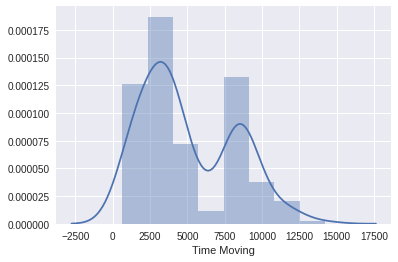

In [10]:
sns.distplot(df_cycling['Time Moving'])

#### Distance Distribution 

Frequency of distance travellled, it's a bimodal distribution that's slightly positively skewed.

In [11]:
df_cycling['Distance'].skew()

0.5135868379757468

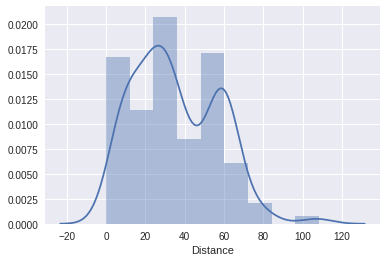

In [12]:
sns.distplot(df_cycling['Distance'])

#### Average Speed Distribution 

The distribution is bimodal, the individual distributions are normal to slightly skewed. 

In [13]:
df_cycling['Average Speed'].skew()

0.43621318841282203

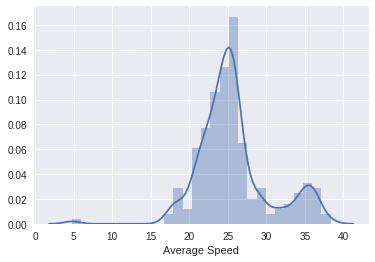

In [14]:
sns.distplot(df_cycling['Average Speed'])

#### Average Power Distribution 

The average power is slightly skewed, the skewness values is around 1 to 0.5

In [15]:
df_cycling['Average Power'].skew()

0.5408197937668116

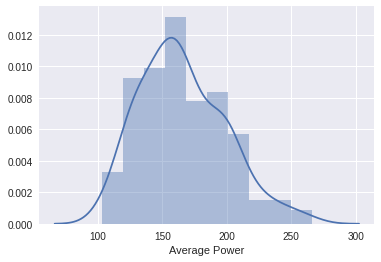

In [16]:
sns.distplot(df_cycling['Average Power'])

#### TSS Distribution

The skewness value is +1 and is definitely highly skewed 

In [17]:
df_cycling['TSS'].skew()

1.0832346587856845

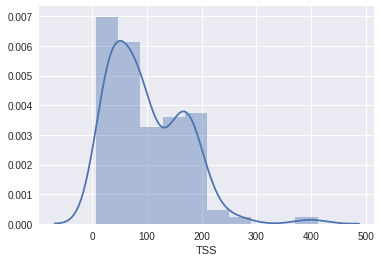

In [18]:
sns.distplot(df_cycling['TSS'], bins=10)

### Correlation between key variables

Exploring the relationships between the main variables can be done with a simple correlation matrix/heatmap that helps notice relationships or dependancies.

The highest correlation in the heatmap is between three variables with each other (`distance`, `Moving Time` and `TSS`) as high as 0.9. Followed by `Elevation Gain` with `TSS`, `Moving Time` and `distance` around 0.8.

Meanwhile, the lowest correlation is between `average_watts` with `distance`, `Elevation Gain` with `Average Heart Rate` and `TSS` with `Average Speed` around 0.03

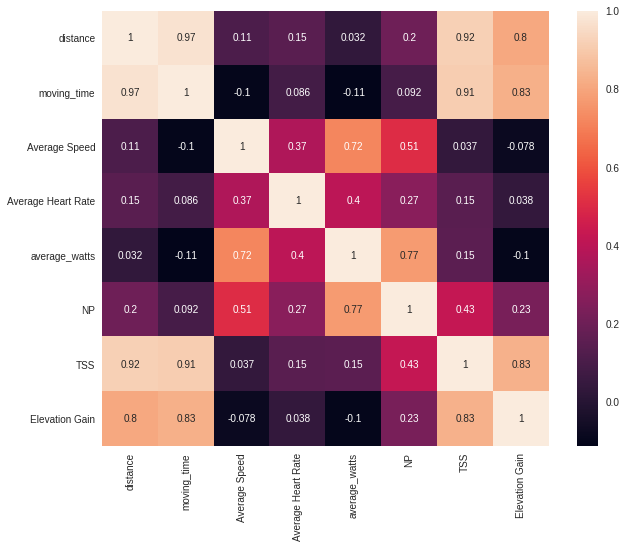

In [19]:
df_cycling_filter = df_cycling[['distance', 'moving_time', 'Average Speed','Average Heart Rate','average_watts','NP','TSS','Elevation Gain']]
corr = df_cycling_filter.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True)

### Race vs Ride, which one's challenging?

Some of the rides are designated as "Race" in the workout_type field, and most expect that these would be the most challenging rides. Normalised Power (NP) is a good measure of how hard a ride is. Exploring the values of NP for races vs the overall set of rides can help check if our hypothesis stands (using graphs and summary statistics). Helps realise which one is more challenging

The following code just selects 'Race' and 'Ride' rows (present in the `workout_type`) from the dataframe.

A boxplot grouped by `workout_type` from this data helps notice the difference in mean values of 'Race' and 'Ride' individually. The `NP` value for 'Race' is clearly much higher than 'Ride'. There does seem to be a few outliers from 'Ride' that are higher than the NP mean of 'Race'

<Figure size 720x576 with 0 Axes>

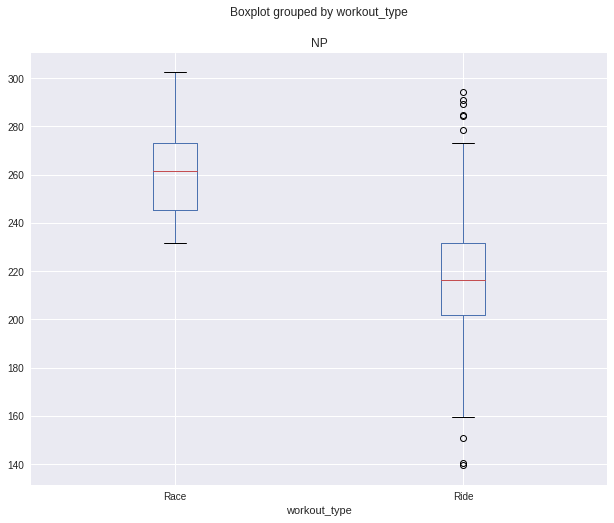

In [177]:
plt.figure(figsize=(10,8))
df_cycling[df_cycling['workout_type']!='Workout'].boxplot(column=['NP'], by='workout_type', figsize=(10,8))

The following code is the summary statistics of the boxplot graph.  

In [21]:
df_cycling[df_cycling['workout_type']!='Workout'].groupby(['workout_type'])['NP'].describe()

,count,mean,std,min,25%,50%,75%,max
workout_type,,,,,,,,
Race,29.0,259.659103,18.503989,231.614,245.3650,261.378,273.058,302.396
Ride,151.0,216.283397,27.934810,139.591,201.9385,216.392,231.767,294.308


### Summary of rides over the year

A summary of rides can be shown throughout the period of data with a few variables across a timeseries plot. Total distance, total TSS and average speed against time can help visualize activity over the year

The following code helps index `df_cycling` better based on year and month. Distance and TSS columns are selected while computing a 'sum' across every month, while Average Speed is selected computing an mean for each month. This is saved in `df_cycling_monthly`

In [0]:
df_cycling_monthly = df_cycling.groupby([df_cycling.index.year,df_cycling.index.month]).agg('sum')[['distance','TSS']]
df_cycling_monthly['Average Speed'] = df_cycling.groupby([df_cycling.index.year,df_cycling.index.month]).agg('mean')['Average Speed']

A common axis subplot of the three variables helps understand the trend over the period of data. the distance and TSS variables appear to have a very similar pattern across the year, which explains the high correlation discussed before, there appears to be a huge peak around November, 2018.

Average speed displayed on the graph however varies around a very small range (from 20 to 30). From May, 2018 there seems to be a steady pattern of increase of speed every two months with a decline on the third which continues till April, 2019 on a high and remains almost steady.

Text(0.5, 0, '(Year,Month)')

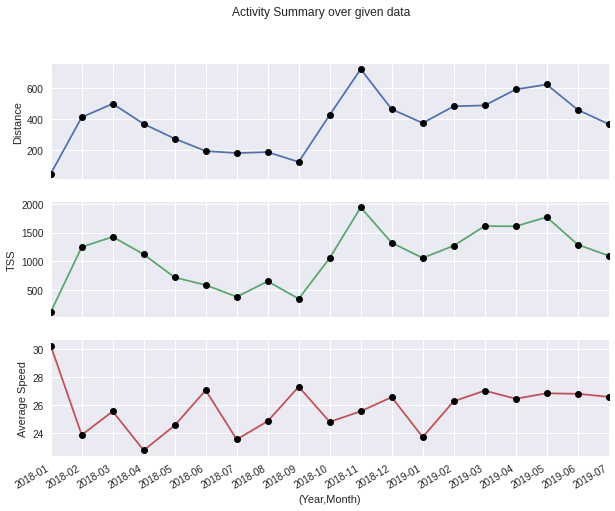

In [173]:
ax = df_cycling_monthly.plot(subplots=True, layout=(3,1), figsize=(10,8),marker='o',markerfacecolor='black', title='Activity Summary over given data', legend=False)
ax[0][0].set_ylabel('Distance')
ax[1][0].set_ylabel('TSS')
ax[2][0].set_ylabel('Average Speed')
ax[0][0].set_xticks(range(len(df_cycling_summary)))
ax[0][0].set_xticklabels(["%s-%02d" % item for item in df_cycling_monthly.index.tolist()])
plt.xlabel('(Year,Month)')

### What indicates a rides popularity?


What leads to more kudos? Exploring the relationship between the main variables and kudos by using a correlation matrix can help indicate which key variables make it popular. A familiar trend of a few variables against kudos should show indicators of popularity and how much they factor in.

The following code block makes a new dataframe called `kudos_corr`, firstly all zero value columns are removed from original dataframe and saved into `kudos_corr`. Later a correlation function 'corr()' is used for Kudos vs every other variable present and sorted from the highest to lowest correlation.

The block represents a list of variables that have a correlation with kudos higher than 0.65

In [114]:
kudos_corr = df_cycling.loc[:, (df_cycling != 0).any(axis=0)] #columns with all zero values dropped
kudos_corr = pd.DataFrame(kudos_corr.corr()['kudos'].sort_values(ascending = False))
kudos_corr[kudos_corr['kudos']>0.65]

,kudos
kudos,1.000000
Aerobic TISS,0.759824
Distance,0.752355
Distance Swim,0.752355
distance,0.752259
TRIMP Zonal Points,0.732845
W' Work,0.729565
P6 Time in Pace Zone,0.715687
L7 Time in Zone,0.714275
Work,0.710227


A few selected from the list are 'Distance', 'Aerobic TISS', 'TSS', 'BikeStress', 'BikeScore', 'Work' and 'Time Moving'. We do notice however that the values of 'Work' and 'Time Moving' are much huger in scale compared to the other and are therefore omitted in the graph.

The following block groups the `df_cycling` dataframe based on its kudos value, a mean for each kudos value is taken for the remaining columns and the variables mentioned are plotted against kudos. There should be a positive sloped line graph showing how they contribute to the popularity 

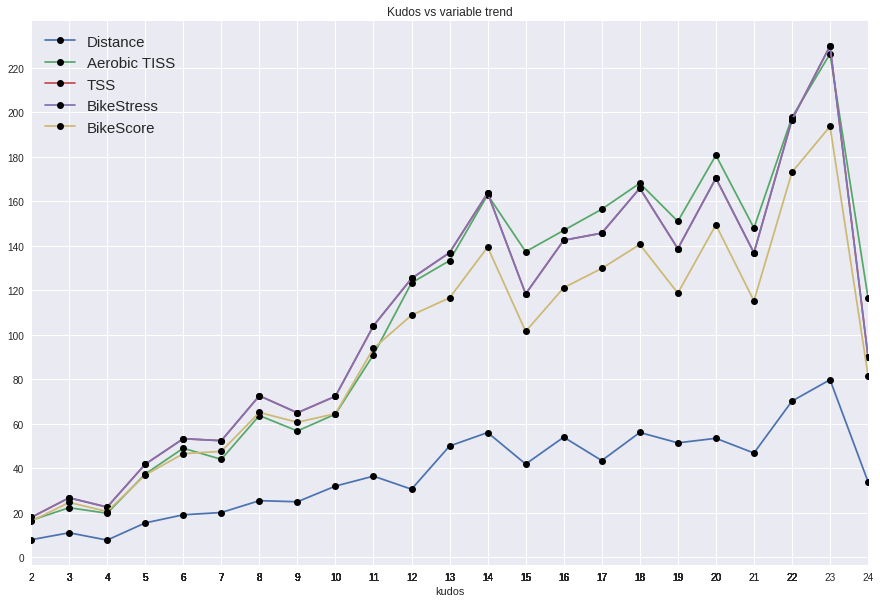

In [100]:
df_cycling.groupby(['kudos']).agg('mean').plot(y=['Distance','Aerobic TISS','TSS','BikeStress','BikeScore'], figsize=(15,10), marker='o',markerfacecolor='black', xticks=df_cycling['kudos'], yticks=np.arange(0, 240, 20), title='Kudos vs variable trend')
plt.legend(fontsize=15)


Noticing a negative trend however, shows variables like 'Best 1000m', 'Best 2000m', 'Best 1500m' contribute to the popularity. The lesser the time taken the more popular they are.

In [170]:
kudos_corr[kudos_corr['kudos']<-0.6]

,kudos
Best 2000m,-0.604723
Best 1500m,-0.617968
Best 1000m,-0.628320


### Daily distance summary graph

This summary graph represents the overall activity for a given month with the sum of the values for each day of the month shown. 

The following block of code is very similar to "Summary of rides over the year" block, instead the main dataframe is grouped not just on a monthly but daily basis, the sum is taken for distance and TSS for the same day and average for speed. 

`df_cycling_daily` now has a daily activity summary of TSS, distance and average speed.

In [0]:
df_cycling_daily = df_cycling.groupby([df_cycling.index.year,df_cycling.index.month,df_cycling.index.day]).agg('sum')[['distance','TSS']]
df_cycling_daily['Average Speed'] = df_cycling.groupby([df_cycling.index.year,df_cycling.index.month,df_cycling.index.day]).agg('mean')['Average Speed']

#### User defined daily summary for given month 

I've decided to create a summary graph in two different ways, this graph requires the user to enter which month of any year they'd like to see the summary of, they also have the option to chose from a scatter plot or a bar chart to visualize the three 'activity' variables on a daily basis for the given month.

Enter the year for the graph (2018 o 2019):

In [121]:
year = int(input())

2018


Enter the month for the graph as number (if you have chosen 2019, choose from 1 to 7 only):

In [122]:
month = int(input())

11


Enter :

1 for Scatter Plot

2 for Bar Chart

In [168]:
plot = int(input())
if plot not in [1,2]: print("Enter a valid number")

2


This block converts month number to corresponding name for plot labelling

In [0]:
month_name =[]
for i in range(1,13):
  month_name.append(calendar.month_name[i])

This block creates the needed summary graph based on the inputs given by the user. it's a 3x1 subplot of distance, TSS and average speed with a a common x-axis being the days of activity. 

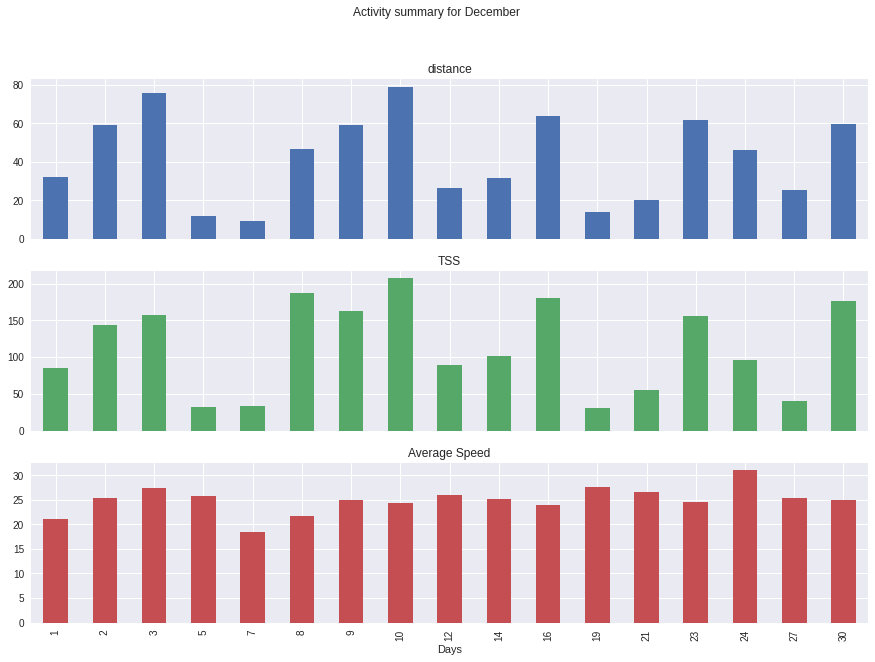

In [169]:
if plot == 1: 
  ax = df_cycling_daily.loc[(year,month)].plot(subplots=True, layout=(3,1), figsize=(15,10),marker='o',markerfacecolor='black', title='Activity summary for '+month_name[month], xticks=df_cycling_daily.loc[(year,month)].index.to_list(), legend=False)
  ax[0][0].set_ylabel('Distance')
  ax[1][0].set_ylabel('TSS')
  ax[2][0].set_ylabel('Average Speed')
  plt.xlabel('Days')
elif plot ==2:
  df_cycling_daily.loc[(year,month)].plot(subplots=True, layout=(3,1), figsize=(15,10), kind='bar', title='Activity summary for '+month_name[month], legend=False)
  plt.xlabel('Days')

#### Overall daily summary for given year 

This consists of two graphs, one for each year. Each graph consists of subplots for each month which inturn consists of daily activity presented by the 3 variables. 

The following block is a subplot for the year 2018 with all the months present. It consists of 3 rows and 4 columns sharing a y-axis for common scaling. Data is selected only for the year 2018 and looped across every month and plotted accordingly into each subplot. A bar graph is chosen for aesthetic purposes and also shows the 3 variables better since they're in one graph.

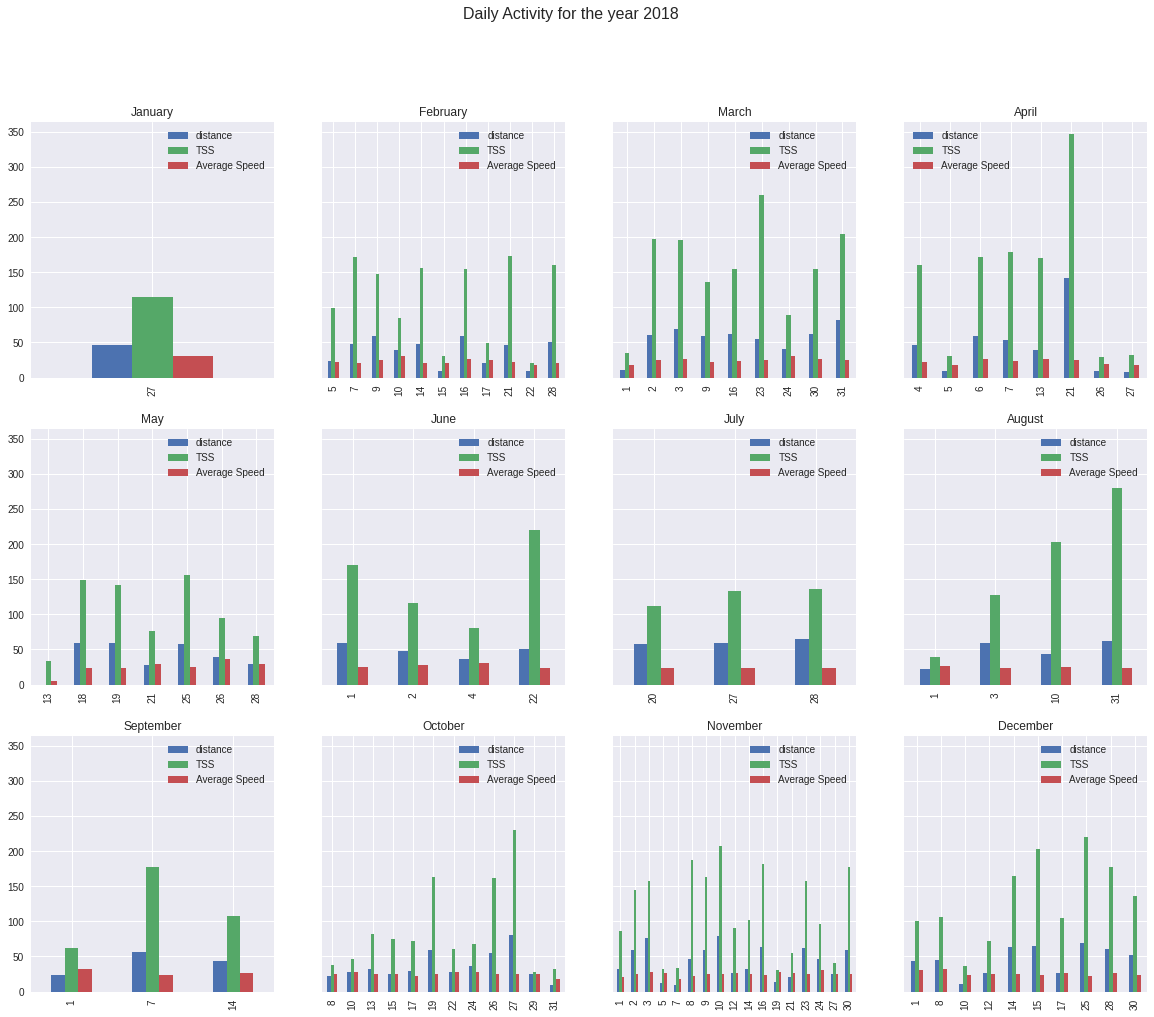

In [166]:
fig, axes = plt.subplots(nrows=3, ncols=4,sharey=True)
fig.suptitle("Daily Activity for the year 2018", fontsize=16)
axes = axes.flatten()
for i in range(0,12):
    df_cycling_daily.loc[(2018,i+1)].plot(ax=axes[i], figsize=(20,16),title=month_name[i], kind='bar')


The following block is a subplot for the year 2019 with months from January to July. Consists of 2 rows and 4 columns for each month while the last subplot is deleted (no data after June). There appears to be more activity compared to 2018 in general.

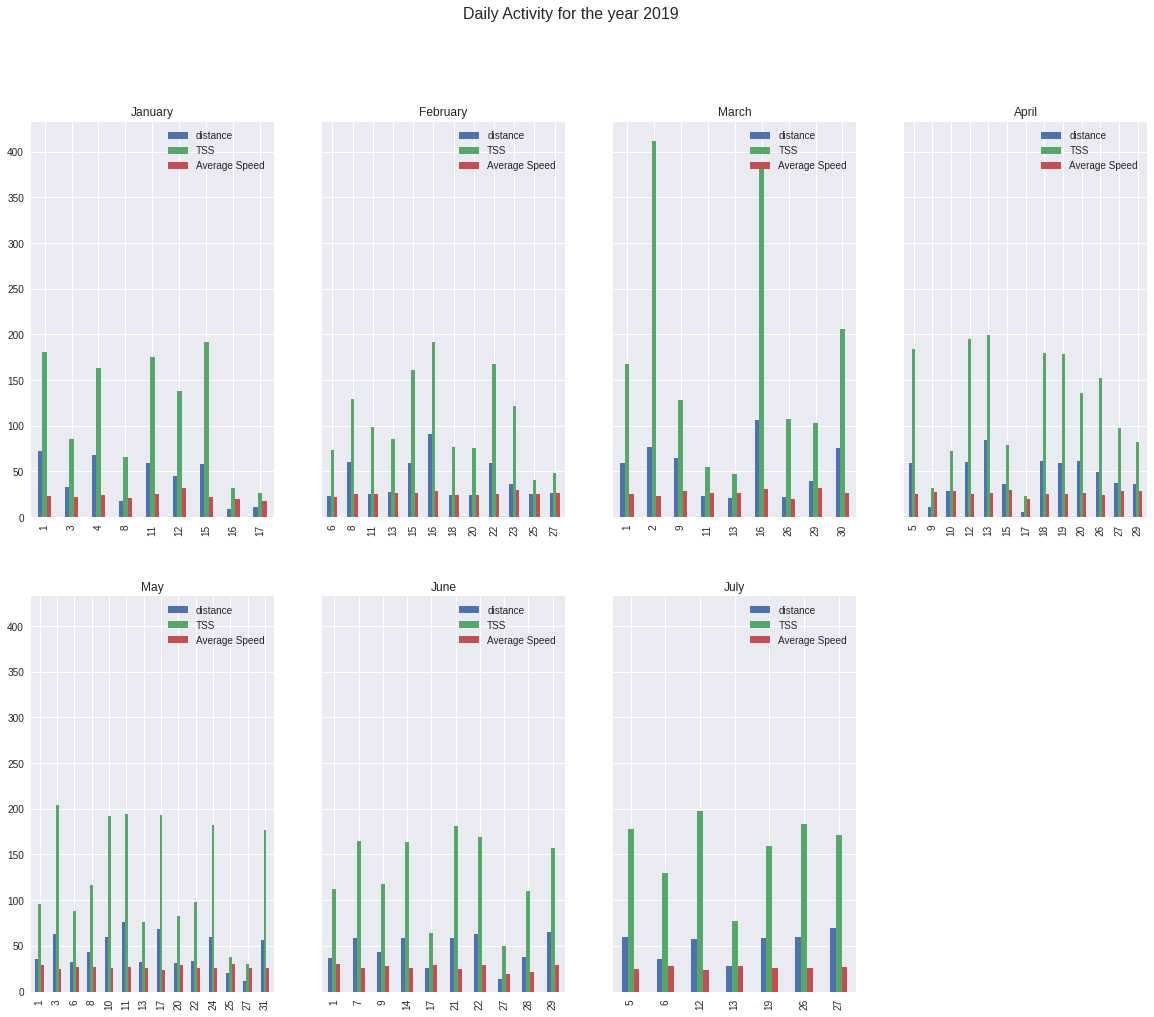

In [167]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True)
fig.suptitle("Daily Activity for the year 2019", fontsize=16)
axes = axes.flatten()
fig.delaxes(axes[7])
for i in range(0,7):
    df_cycling_daily.loc[(2019,i+1)].plot(ax=axes[i],kind='bar', figsize=(20,16),title=month_name[i])